# Generating SDF Fields from MNIST and confirming validity

In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt as edt



In [2]:
# Load MNIST grayscale (no resize here)
mnist = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())

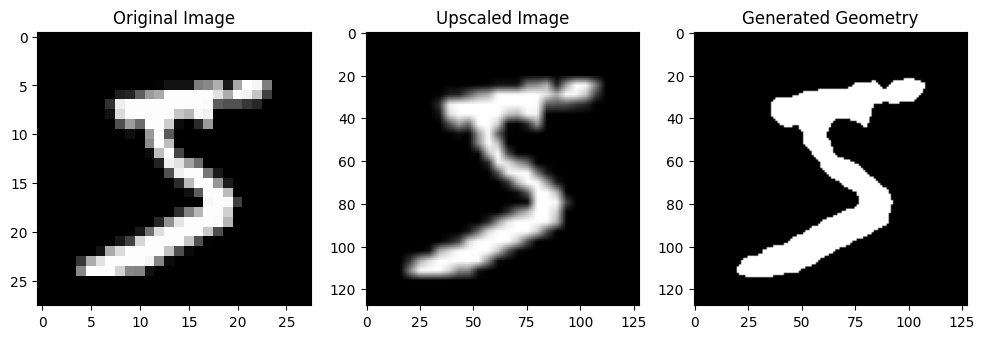

In [3]:
img28, label = mnist[0]                   # img28: [1,28,28] in [0,1]

# Resize FIRST (antialiased), then threshold
target_size = (128, 128)
resize = transforms.Resize(target_size, antialias=True)  # bilinear for PIL under the hood
img128 = resize(img28)                     # [1,128,128], still grayscale
# Threshold to create binary mask
threshold = 0.4
mask = (img128 >= threshold).float()       # binary mask [1,128,128]    


# Visualize
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img28.squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Upscaled Image")
plt.imshow(img128.squeeze(), cmap='gray')


plt.subplot(1, 3, 3)
plt.title("Generated Geometry")
plt.imshow(mask.squeeze(), cmap='gray')
plt.savefig("./figures/upscale_mnist.png", bbox_inches='tight', dpi=300)
plt.show()

# Calculating the SDF Field

In [4]:
mask = (mask.squeeze().detach().cpu().numpy()).astype(np.uint8)

# Distances: edt computes, for each ZERO pixel, distance to nearest NON-ZERO pixel
dist_outside = edt(mask == 0)  # distance for background pixels to the digit
dist_inside  = edt(mask == 1)  # distance for foreground pixels to the background

sdf = dist_outside - dist_inside          # NEGATIVE inside (mask==1), POSITIVE outside

# Optional: match MetaSDF scale (divide by image width) - sdf /= float(mask.shape[1])

In [5]:
inside  = sdf[mask == 1]; outside = sdf[mask == 0]
print(inside.mean(), outside.mean())  # expect inside < 0, outside > 0


-3.6613700428864604 17.473416675269974


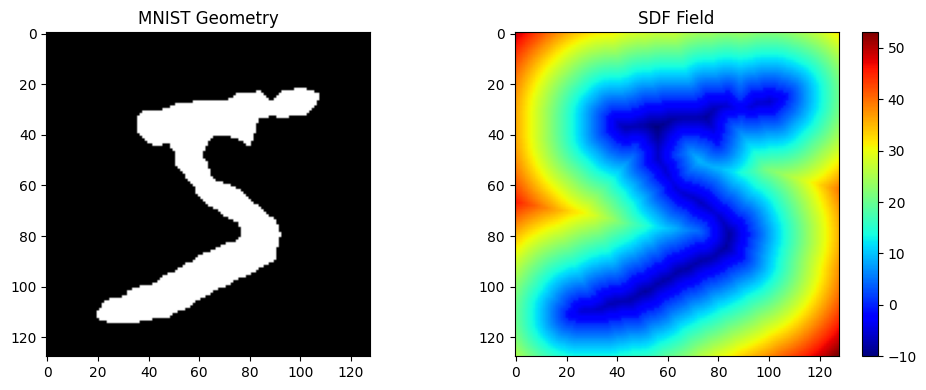

In [6]:

# Visualize
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("MNIST Geometry")
plt.imshow(mask.squeeze(), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("SDF Field")
plt.imshow(sdf.squeeze(), cmap='jet')
plt.colorbar()

plt.tight_layout()
plt.savefig("./figures/mnist_field.png", bbox_inches='tight', dpi=300)
plt.show()

In [7]:

# # --- INPUTS ---
# # binary_mask: raw MNIST mask (values 0-1, shape [1,H,W] or [H,W])
# # sdf_field: signed distance function (negative inside, positive outside)
# # Assume both are already computed and available.

# # --- 1. Prepare geometry and SDF data ---
# binary_mask_2d = (mask.squeeze() >= 0.5).astype(np.uint8)  # Convert to 2D 0/1 mask
# sdf_values     = sdf                                       # [H,W] array of SDF values

# height, width = sdf_values.shape

# # Create coordinate grids for contour plotting (Y=row indices, X=column indices)
# grid_y, grid_x = np.mgrid[0:height, 0:width]

# # --- 2. Choose robust, symmetric contour levels for visualization ---
# max_display_sdf = np.percentile(np.abs(sdf_values), 98)  # ignore extreme outliers
# contour_levels  = np.linspace(-max_display_sdf, max_display_sdf, 13)

# # --- 3. Create figure with two panels ---
# fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# # --- 4. Left Panel: Geometry Mask ---
# axes[0].imshow(binary_mask_2d, cmap="gray", origin="upper", interpolation="nearest")
# axes[0].set_aspect("equal")
# axes[0].axis("off")
# axes[0].set_title("MNIST Geometry")

# # --- 5. Right Panel: SDF Field with Contours ---
# # Filled contours (SDF magnitude as color bands)
# filled_contours = axes[1].contourf(grid_x, grid_y, sdf_values,
#                                    levels=contour_levels,
#                                    cmap="Spectral_r",
#                                    extend="both")

# # Overlay thin contour lines for reference
# axes[1].contour(grid_x, grid_y, sdf_values,
#                 levels=contour_levels,
#                 colors="k", linewidths=0.8)

# # Highlight the zero level set (shape boundary) with a thick black line
# axes[1].contour(grid_x, grid_y, sdf_values,
#                 levels=[0.0],
#                 colors="k", linewidths=2.0)

# # Match imshow’s "top-left origin" convention
# axes[1].invert_yaxis()
# axes[1].set_aspect("equal")
# axes[1].axis("off")
# axes[1].set_title("SDF Field")

# # Add a colorbar for SDF values
# fig.colorbar(filled_contours, ax=axes[1], fraction=0.046, pad=0.04)

# # --- 6. Final layout and saving ---
# plt.tight_layout()
# plt.savefig("./figures/mnist_sdf_visualization.png",
#             bbox_inches='tight', dpi=300)
# plt.show()


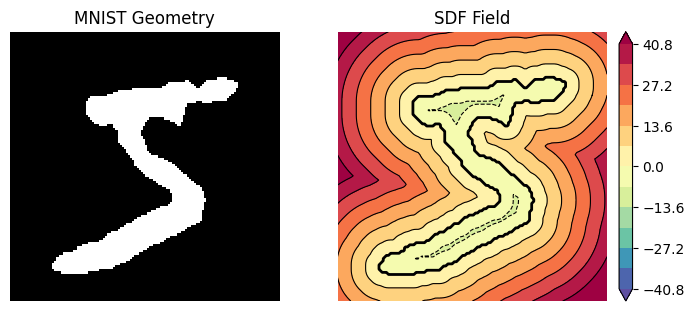

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_mask_and_sdf(mask, sdf, out_path="./figures/mnist_sdf_visualization.png"):
    """
    mask: torch.Tensor or np.ndarray, shape [H,W] or [1,H,W], values in [0,1]
    sdf : torch.Tensor or np.ndarray, shape [H,W], signed distance (neg inside, pos outside)
    """
    # --- Normalize inputs to numpy ---
    def to_numpy(x):
        try:
            import torch
            if isinstance(x, torch.Tensor):
                return x.detach().cpu().numpy()
        except ImportError:
            pass
        return np.asarray(x)

    mask_np = to_numpy(mask)
    sdf_np  = to_numpy(sdf).astype(np.float64)

    # --- Prepare geometry and SDF data ---
    binary_mask_2d = (np.squeeze(mask_np) >= 0.5).astype(np.uint8)  # [H,W]
    sdf_values     = np.squeeze(sdf_np)                             # [H,W]

    if binary_mask_2d.ndim != 2 or sdf_values.ndim != 2:
        raise ValueError("mask and sdf must become 2D after squeeze.")

    height, width = sdf_values.shape
    grid_y, grid_x = np.mgrid[0:height, 0:width]

    # --- Robust symmetric contour levels ---
    max_display_sdf = np.percentile(np.abs(sdf_values), 98)
    if max_display_sdf == 0:
        max_display_sdf = np.max(np.abs(sdf_values)) or 1.0
    contour_levels  = np.linspace(-max_display_sdf, max_display_sdf, 13)

    # --- Figure ---
    fig, axes = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)

    # Left: geometry mask
    axes[0].imshow(binary_mask_2d, cmap="gray", origin="upper", interpolation="nearest")
    axes[0].set_aspect("equal"); axes[0].axis("off"); axes[0].set_title("MNIST Geometry")

    # Right: SDF
    cf = axes[1].contourf(grid_x, grid_y, sdf_values,
                          levels=contour_levels, cmap="Spectral_r", extend="both")
    axes[1].contour(grid_x, grid_y, sdf_values, levels=contour_levels, colors="k", linewidths=0.8)
    axes[1].contour(grid_x, grid_y, sdf_values, levels=[0.0], colors="k", linewidths=2.0)
    axes[1].invert_yaxis()
    axes[1].set_aspect("equal"); axes[1].axis("off"); axes[1].set_title("SDF Field")
    fig.colorbar(cf, ax=axes[1], fraction=0.046, pad=0.04)

    # --- Save safely ---
    if out_path is not None:
        out_dir = os.path.dirname(out_path)
        if out_dir and not os.path.exists(out_dir):
            os.makedirs(out_dir, exist_ok=True)
        fig.savefig(out_path, bbox_inches='tight', dpi=300)

    # Show and close to avoid leaking state into later cells
    plt.show()
    plt.close(fig)

# Usage:
plot_mask_and_sdf(mask, sdf)


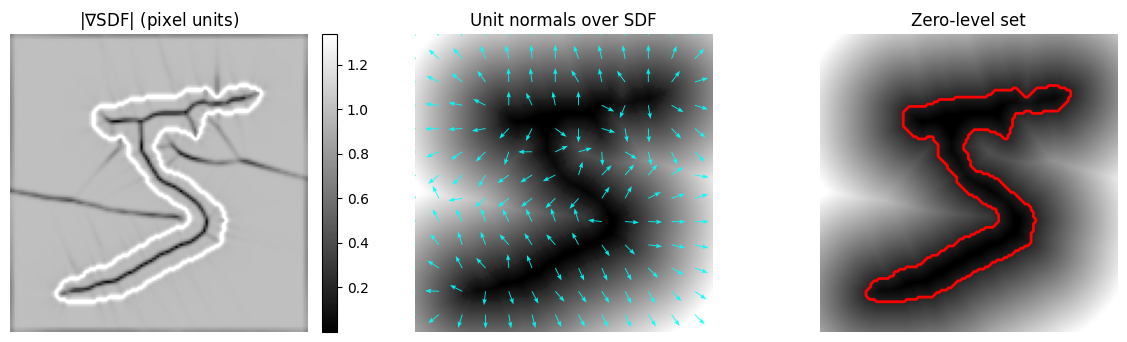

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def visualize_sdf_normals(
    sdf,
    spacing=(1.0, 1.0),    # (dy, dx)
    stride=10,             # arrow sampling step
    arrow_len=6.0,         # arrow length in pixels (data units)
    smooth_sigma=0.8,      # Gaussian smoothing before gradient to reduce noise/banding
    clip_pct=99.0,         # grayscale clipping for prettier contrast
    cmap_gray="gray",
):
    """
    Make 3 panels:
      1) |∇SDF| magnitude with φ=0 outline
      2) Unit normals (quiver) over grayscale SDF
      3) Grayscale SDF with red φ=0 curve
    """
    sdf = np.asarray(sdf)
    H, W = sdf.shape
    dy, dx = spacing

    # optional smoothing to stabilize gradients
    if smooth_sigma and smooth_sigma > 0:
        sdf_s = gaussian_filter(sdf, smooth_sigma)
    else:
        sdf_s = sdf

    # gradient and unit normals
    gy, gx = np.gradient(sdf_s, dy, dx)
    grad_norm = np.sqrt(gx**2 + gy**2) + 1e-12
    nx, ny = gx / grad_norm, gy / grad_norm   # outward for standard SDF (neg inside, pos outside)

    # coordinates
    yy, xx = np.mgrid[0:H, 0:W]

    # downsample uniformly
    samp = np.zeros_like(sdf, dtype=bool)
    samp[::stride, ::stride] = True

    # fixed-length arrows in data units
    ux = nx * arrow_len
    uy = ny * arrow_len

    # pretty grayscale ranges
    mag_max = np.percentile(grad_norm, clip_pct)
    sdf_lo, sdf_hi = np.percentile(sdf, [100-clip_pct, clip_pct])

    # --- plotting ---
    fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))

    # 1) |∇φ|
    im0 = axs[0].imshow(np.clip(grad_norm, 0, mag_max), cmap=cmap_gray, origin="upper")
    axs[0].contour(xx, yy, sdf, levels=[0.0], colors="w", linewidths=2)
    axs[0].set_title(r"$|\nabla \mathrm{SDF}|$ (pixel units)")
    axs[0].axis("off")
    fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    # 2) normals over SDF
    im1 = axs[1].imshow(np.clip(sdf, sdf_lo, sdf_hi), cmap=cmap_gray, origin="upper")
    axs[1].quiver(xx[samp], yy[samp], ux[samp], uy[samp],
                  angles="xy", scale_units="xy", scale=1.0,
                  color=(0,1,1,0.9), width=0.003, headwidth=5, headlength=7, headaxislength=6)
    axs[1].set_title("Unit normals over SDF")
    axs[1].axis("off")

    # 3) φ with red zero-level curve
    im2 = axs[2].imshow(np.clip(sdf, sdf_lo, sdf_hi), cmap=cmap_gray, origin="upper")
    axs[2].contour(xx, yy, sdf, levels=[0.0], colors="r", linewidths=2)
    axs[2].set_title("Zero-level set")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

visualize_sdf_normals(
    sdf,
    stride=10,          # try 8–12 depending on resolution
    arrow_len=6.0,      # 5–8 is usually good
    smooth_sigma=0.8,   # set to 0 to disable smoothing
    clip_pct=99.0,
)



# band = 4.0  # pixels
# mask = np.abs(sdf) <= band
# samp = np.zeros_like(sdf, dtype=bool); samp[::stride, ::stride] = True
# samp &= mask
